In [14]:
!pip install --upgrade google-meridian[colab,and-cuda]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.6/813.6 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.7/590.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 13.6 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


In [2]:
# To visualize all columns
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('national_media.csv')

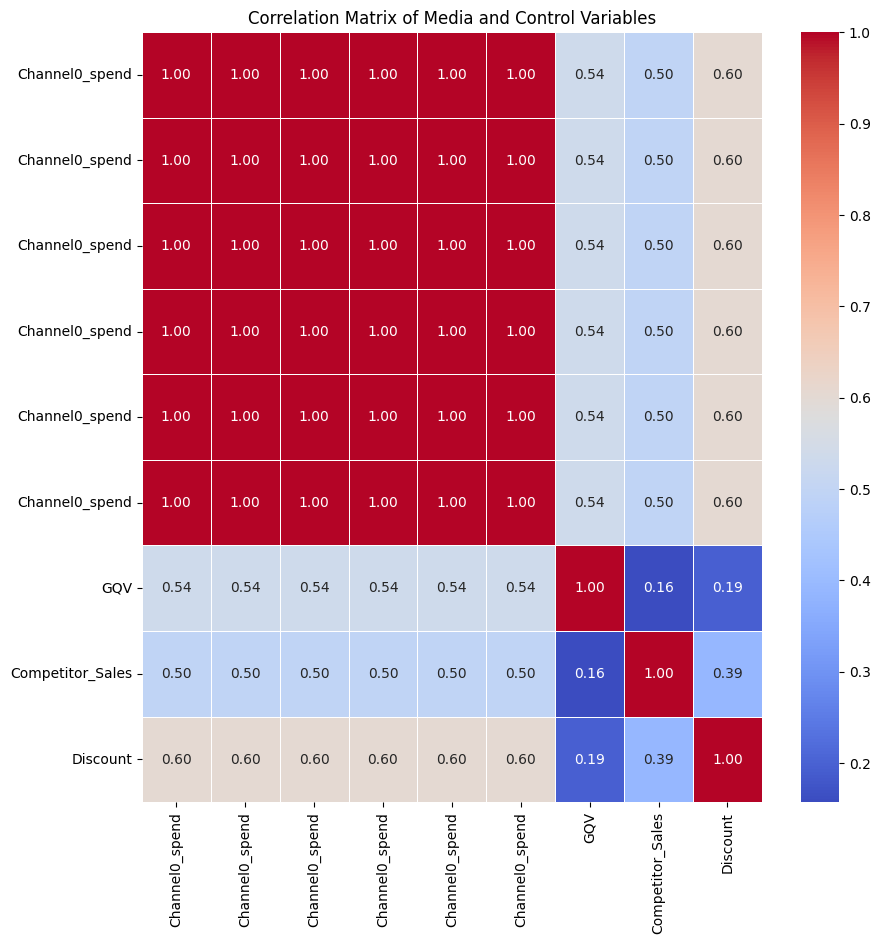

In [9]:
# Check correlation between channels
correlation_matrix = df[['Channel0_spend', 'Channel0_spend', 'Channel0_spend', 'Channel0_spend', 'Channel0_spend', 'Channel0_spend', 'GQV', 'Competitor_Sales', 'Discount']].corr()

# Plot heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Media and Control Variables")
plt.show()

In [10]:
# Mapping the columns to their corresponding categories
coord_to_columns = load.CoordToColumns(
    time='time',
    controls=['Discount', 'Competitor_Sales', 'GQV'],
    kpi='conversions',
    revenue_per_kpi='revenue_per_conversion',
    media=[
        'Channel0_impression',
        'Channel1_impression',
        'Channel2_impression',
        'Channel3_impression'
    ],
    media_spend=[
        'Channel0_spend',
        'Channel1_spend',
        'Channel2_spend',
        'Channel3_spend'
    ],
    reach =['Channel4_reach', 'Channel5_reach'],
    frequency=['Channel4_frequency', 'Channel5_frequency'],
    rf_spend=['Channel4_spend', 'Channel5_spend'],
)

In [11]:
# Mapping the channel to their spends and impressions
  correct_media_to_channel = {
    'Channel0_impression': 'Channel0',
    'Channel1_impression': 'Channel1',
    'Channel2_impression': 'Channel2',
    'Channel3_impression': 'Channel3'
}
correct_media_spend_to_channel = {
    'Channel0_spend': 'Channel0',
    'Channel1_spend': 'Channel1',
    'Channel2_spend': 'Channel2',
    'Channel3_spend': 'Channel3'
}

correct_reach_to_channel = {
    'Channel4_reach': 'Channel4',
    'Channel5_reach': 'Channel5'
}
correct_frequency_to_channel = {
    'Channel4_frequency': 'Channel4',
    'Channel5_frequency': 'Channel5'
}
correct_rf_spend_to_channel = {
    'Channel4_spend': 'Channel4',
    'Channel5_spend': 'Channel5'
}

In [12]:
# Loading the mapping onto their loader
loader = load.CsvDataLoader(
    csv_path=f'/content/national_media.csv',
    kpi_type='non_revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=correct_media_to_channel,
    media_spend_to_channel=correct_media_spend_to_channel,
    reach_to_channel=correct_reach_to_channel,
    frequency_to_channel=correct_frequency_to_channel,
    rf_spend_to_channel=correct_rf_spend_to_channel,
)
data = loader.load()

/usr/local/lib/python3.11/dist-packages/meridian/data/load.py:1020: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[geo_column_name] = self.df[geo_column_name].replace(
/usr/local/lib/python3.11/dist-packages/meridian/data/load.py:201: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if (constants.GEO) not in self.dataset.dims.keys():
/usr/local/lib/python3.11/dist-packages/meridian/data/load.py:206: UserWarning: The `population` argument is ignored in a nationally aggregated model. It will be reset to [1]
  warnings.warn(
/usr/local/lib/python3.11/dist-pac

In [13]:
# Setting priors
roi_mu = 0.2     # Mu for ROI prior for each media channel.
roi_sigma = 0.9  # Sigma for ROI prior for each media channel.
prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_mu, roi_sigma, name=constants.ROI_M)
)
model_spec = spec.ModelSpec(prior=prior)

mmm = model.Meridian(input_data=data, model_spec=model_spec)

/usr/local/lib/python3.11/dist-packages/meridian/model/model.py:67: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(


In [14]:
%%time
# MCMC sampling for prior and posterior
mmm.sample_prior(500)
mmm.sample_posterior(n_chains=7, n_adapt=500, n_burnin=500, n_keep=1000)

/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_om has been automatically set to

CPU times: user 8min 47s, sys: 29 s, total: 9min 16s
Wall time: 9min 21s


/usr/local/lib/python3.11/dist-packages/arviz/data/inference_data.py:157: UserWarning: trace group is not defined in the InferenceData scheme
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/data/inference_data.py:1655: UserWarning: trace group is not defined in the InferenceData scheme
  warnings.warn(


In [15]:
# R-Hat  plots for the coefficients
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [16]:
# Model Fit visualization
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()

/usr/local/lib/python3.11/dist-packages/meridian/analysis/analyzer.py:182: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [17]:
# Defining summarizer
mmm_summarizer = summarizer.Summarizer(mmm)

In [18]:
# Connecting Drive to store summarizer
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
from datetime import datetime

In [20]:
# Save the summary
filepath = '/content/drive/MyDrive'
start_date = datetime.strptime('2021-01-25', '%Y-%m-%d').date()
end_date = datetime.strptime('2024-01-15', '%Y-%m-%d').date()
mmm_summarizer.output_model_results_summary('summary_output.html', filepath, start_date, end_date)

/usr/local/lib/python3.11/dist-packages/meridian/analysis/analyzer.py:182: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.11/dist-packages/meridian/analysis/analyzer.py:182: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  w

In [21]:
# Show the summary
IPython.display.HTML(filename='/content/drive/MyDrive/summary_output.html')

Dataset,R-squared,MAPE,wMAPE
All Data,0.34,5%,4%


In [20]:
%%time
# Define budget optimizer
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()

CPU times: user 2min 57s, sys: 2.4 s, total: 2min 59s
Wall time: 2min 12s


In [21]:
# Defining path to store budget optimizer
filepath = '/content/drive/MyDrive'
optimization_results.output_optimization_summary('optimization_output.html', filepath)

/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: Futu

In [22]:
# Showing the budget optimizer
IPython.display.HTML(filename='/content/drive/MyDrive/optimization_output.html')

Channel,Non-optimized spend,Optimized spend
Channel4,37%,47%
Channel5,20%,18%
Channel1,16%,11%
Channel0,9%,10%
Channel2,13%,9%
Channel3,5%,4%
